# COMPSCI 714 - Assignment 1

This assignment will evaluate the content covered in weeks 1 & 2. This assignment aims at evaluating your coding skills, aligned with what we covered in the lectutorials, but also your critical thinking and self-learning abilities with a few more advanced questions.

**Name**: 

**UPI**: 

**Student ID**: 

## **Part 1: Data loading, exploration, cleaning and pre-processing** - 17 marks

Some of the libraries useful to this part are found in the following cell. You might need to import some more yourself for some of the tasks.

In [1]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
from pathlib import Path

### **Task 1: Load the dataset** - 1 mark
The dataset used in the assignment contains multiple attributes of houses and their target sale price stored in `SalePrice`. \
You can find information about each attribute in the "Housing Price Data Dictionnary.txt" file.

**Task deliverable**:
- Load the dataset contained in the file *house_prices.csv* as a Pandas DataFrame in a variable called `df_data`. 

In [2]:
# Import house_prices data from local path
df_data = pd.read_csv("house_prices.csv") 

### **Task 2: Extract basic dataset information** - 2 marks

**Task deliverable**:

Complete the `extract_basic_info()` function which takes a tabular dataset in the form of a Pandas Dataframe as parameter, and returns a tuple containing the following information:
- The number of instances in the dataset.
- The total number of attributes in the dataset.
- The number of numerical attributes.
- The number of categorical attributes.
- The total memory size of the dataset.

The order of the elements in the returned tuple should follow the same order as follow: (number of instances, totoal number of attributes, number of numerical attributes, number of categorical attributes, total memory size).

**Remarks**: 
- For this task, we define a numerical attribute as an attribute having numeric values. These values could represent a continuous or categorical attribute. Contrastively, we define a symbolic attribute as an attribute having non-numeric values.
- During grading, your function will be tested with the dataset previously loaded, but also with other hidden datasets. Make sure to test it to make sure it works fine on a few other datasets. 

In [3]:
number_numerical = df_data.select_dtypes(include=['number'])
number_numerical.shape

(1460, 35)

In [4]:
def extract_basic_info(df_dataset):
    ''' 
    This function returns number of instances, total number of attributes,
    number of numerical attributesm number of categorical attributes and total memory size of the dataset in bytes
    as tuple
    '''
    # Number of instances (rows) in the dataset
    number_instances = df_dataset.shape[0]
    
    # Total number of attributes (columns) in the dataset
    number_attributes = df_dataset.shape[1]
    
    # Number of numerical attributes
    number_numerical = df_dataset.select_dtypes(include=['number']).shape[1]
    
    # Number of categorical attributes
    number_categorical = df_dataset.select_dtypes(exclude=['number']).shape[1]
    
    # Total memory usage of the dataset in bytes
    memory_size = df_dataset.memory_usage(deep=True).sum()
    
    # Return the tuple with the extracted information
    return (number_instances, number_attributes, number_numerical, number_categorical, memory_size)

results = extract_basic_info(df_data)
results

(1460, 81, 35, 46, np.int64(3919398))

In [5]:
# Check if the results are tuple
print(isinstance(results, tuple)) 

True


### **Task 3: Basic exploration** - 2 marks

#### **Task 3.1 - Histograms of surface attributes** - 1 mark
This question is based on the dataset loaded in Task 1.

**Task deliverable**:
- Identify the 14 attributes representing areas in square feet in the dataset, and plot them as histograms.

**Remark**: Having a look in the data dictionary provided with the dataset might help.


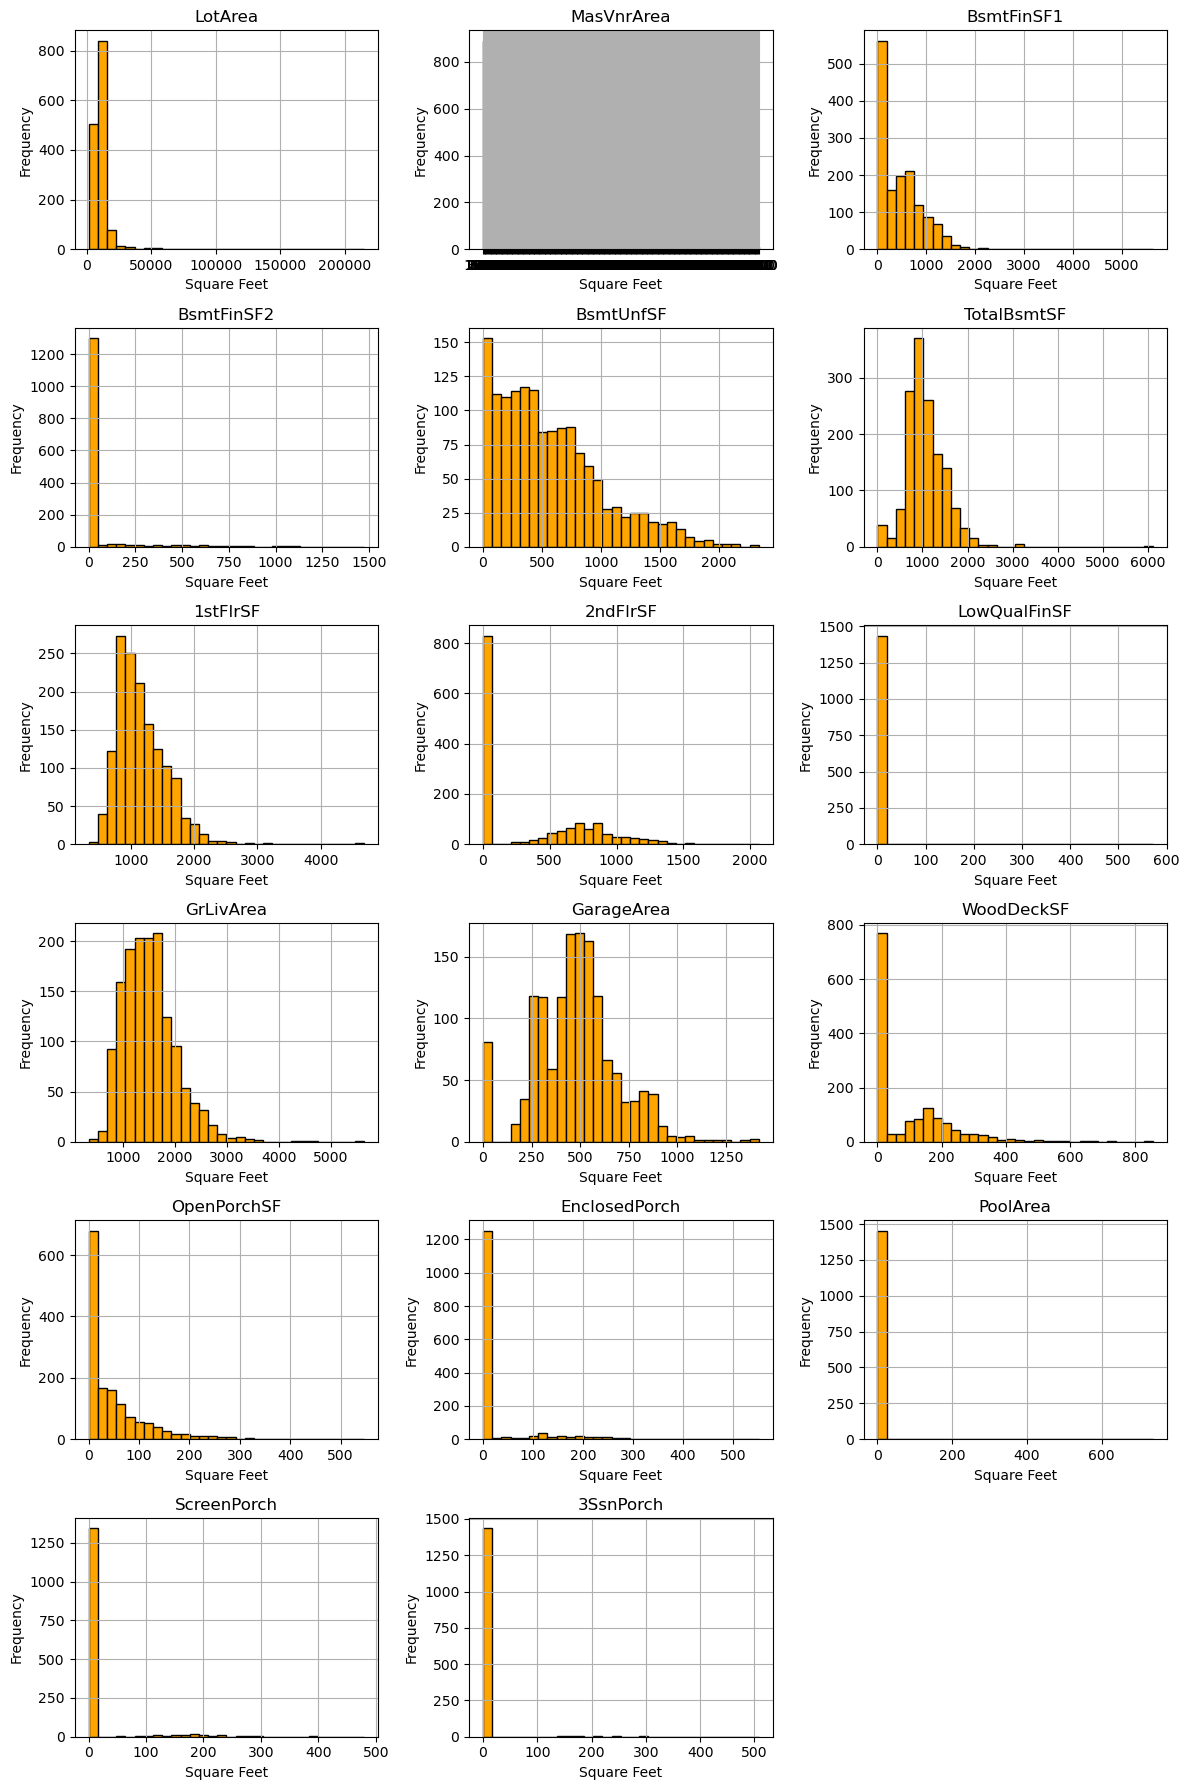

In [10]:
area_attributes = [
    "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF",
    "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
    "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "PoolArea",
    "ScreenPorch", "3SsnPorch"
]
# Plot histograms
plt.figure(figsize=(12, 18))
for i, column in enumerate(area_attributes, 1):
    plt.subplot(6, 3, i)  # Create a 5-row, 3-column grid of subplots
    df_data[column].hist(bins=30, edgecolor="black", color="orange")
    plt.title(column)
    plt.xlabel("Square Feet")
    plt.ylabel("Frequency")

# Adjust layout and show plot
plt.tight_layout()
plt.show()

#### **Task 3.2: Correlations with target** - 1 mark
**Task deliverable**:
- Display in descending order the correlation coefficients between the 14 area attributes identified previously and the target attribute `SalePrice`. 

In [13]:
corr_matrix = df_data[area_attributes + ["SalePrice"]]
# Convert dtype MasVnrArea (object) to float - since there are string ? in the dataset
# Find rows where it occured
df_with_question_marks = corr_matrix[corr_matrix["MasVnrArea"] == "?"]
# Bases on examination of the dataset, we can replace ? with 0
corr_matrix.loc[:, "MasVnrArea"] = corr_matrix["MasVnrArea"].replace("?", 0)
# corr_matrix.loc[:, "MasVnrArea"] = pd.to_numeric(corr_matrix["MasVnrArea"], errors="coerce").astype(float)
corr_mat = corr_matrix.corr().SalePrice.sort_values(ascending=False).drop("SalePrice")
corr_mat


GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
MasVnrArea       0.472614
BsmtFinSF1       0.386420
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
LotArea          0.263843
BsmtUnfSF        0.214479
ScreenPorch      0.111447
PoolArea         0.092404
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
LowQualFinSF    -0.025606
EnclosedPorch   -0.128578
Name: SalePrice, dtype: float64

### **Task 4: Splitting the data in train and test sets** - 4 marks
The dataset has a modest size, so it might be worth investigating the use of stratified sampling.

#### **Task 4.1: Selecting and preparing an attribute for the sampling** - 2 marks

**Task deliverables**:

1. Select the area attribute (from Task 3.2) with the highest correlation to the target `SalePrice`. \
Based on the selected attribute, sort the instances into 4 bins. The bins edges are defined as: [$0$, $median \times 0.5$, $median$, $median \times 1.5$, $\infty$]. \
$median$ corresponds to the median value of the previously selected area attribute's values. \
Create a new attribute corresponding to the category each instance (house) is binned into.
3. Visualise the number of instances (houses) in each category with a bar plot.

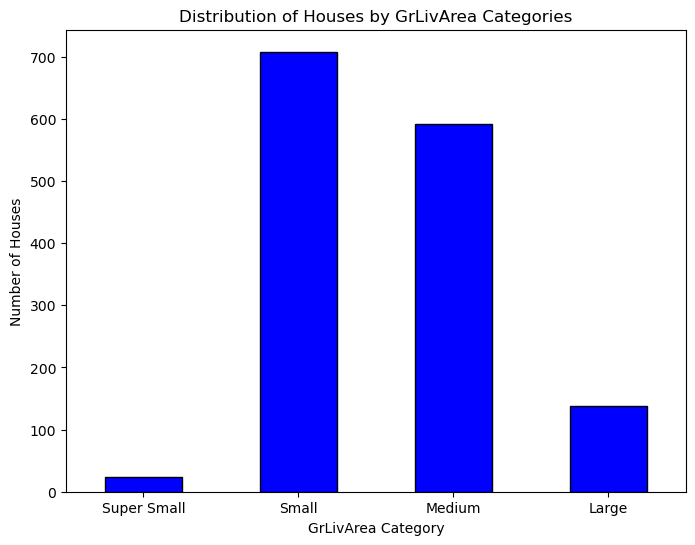

In [14]:
# The most relevant area attribute is GrLivArea - above ground living area square feet

# Step 1: Select GrLivArea and Compute Median
grliv_median = df_data["GrLivArea"].median()

# Step 2: Define Bins into 4 categories 
bins = [0, grliv_median * 0.5, grliv_median, grliv_median * 1.5, np.inf]
labels = ["Super Small", "Small", "Medium", "Large"]

# Step 3: Create a New Column for Binned Categories
df_data["GrLivArea_Category"] = pd.cut(df_data["GrLivArea"], bins=bins, labels=labels, include_lowest=True)

# Step 4: Plot the Number of Houses in Each Category
plt.figure(figsize=(8, 6))
df_data["GrLivArea_Category"].value_counts().sort_index().plot(kind="bar", color="blue", edgecolor="black")
plt.title("Distribution of Houses by GrLivArea Categories")
plt.xlabel("GrLivArea Category")
plt.ylabel("Number of Houses")
plt.xticks(rotation=0)
plt.show()

#### **Task 4.2: Train/valid/test sets split using stratified sampling** - 2 marks

**Task deliverable**:

1. Split the dataset into train, validation and test sets using stratified sampling based on the the new categorical attribute you created in Task 4.1. Use a 60%/20%/20% split for train/validation/test sets.
2. Compare the proportions of instances (in percentage) for each category in:
   - the overall dataset,
   - the stratified train and test sets, and
   - randomly splitted train and test sets (without stratified sampling).
   
   Briefly explain the difference of results between stratified and random sampling. Does the choice of stratified sampling make sense in that case?

**Remark**: 
- Don't forget to drop the new feature created for stratifed sampling from the training and test sets after completing this task.


In [15]:
from sklearn.model_selection import train_test_split
# Create sets for stratified sampling
strat_train_set, strat_temp_set = train_test_split(df_data, test_size=0.4, stratify=df_data["GrLivArea_Category"],random_state=42)
strat_valid_set, strat_test_set = train_test_split(strat_temp_set, test_size=0.5, stratify=strat_temp_set["GrLivArea_Category"], random_state=42)
# len(strat_train_set),len(strat_valid_set),len(strat_test_set) - check for length to make sure correct

# Create sets for random sampling
rand_train_set, rand_temp_set = train_test_split(df_data, test_size=0.4, random_state=42)
rand_valid_set, rand_test_set = train_test_split(rand_temp_set, test_size=0.5, random_state=42)
# len(rand_train_set), len(rand_valid_set), len(rand_test_set) - check for length to make sure correct

# Comparision here
def grlivarea_cat_proportions(data):
    ''' returns propotion between sets and total data '''
    return data["GrLivArea_Category"].value_counts() / len(data)

compare_props = pd.DataFrame({
    "Overall %": grlivarea_cat_proportions(df_data),
    "Stratified Train %": grlivarea_cat_proportions(strat_train_set),
    "Stratified Valid %": grlivarea_cat_proportions(strat_valid_set),
    "Stratified Test %": grlivarea_cat_proportions(strat_test_set),
    "Random Train %": grlivarea_cat_proportions(rand_train_set),
    "Random Valid %": grlivarea_cat_proportions(rand_valid_set),
    "Random Test %": grlivarea_cat_proportions(rand_test_set),
}).sort_index()
compare_props.index.name = "GrLivArea (ground floor living area) Category"
compare_props["Strat. Error Train %"] = (compare_props["Stratified Train %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Strat. Error Valid %"] = (compare_props["Stratified Valid %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Strat. Error Test %"] = (compare_props["Stratified Test %"] /
                                   compare_props["Overall %"] - 1)
compare_props["Rand. Error Train %"] = (compare_props["Random Train %"] /
                                  compare_props["Overall %"] - 1)
compare_props["Rand. Error Valid %"] = (compare_props["Random Valid %"] /
                                  compare_props["Overall %"] - 1)
compare_props["Rand. Error Test %"] = (compare_props["Random Test %"] /
                                  compare_props["Overall %"] - 1)
(compare_props * 100).round(2)


,Overall %,Stratified Train %,Stratified Valid %,Stratified Test %,Random Train %,Random Valid %,Random Test %,Strat. Error Train %,Strat. Error Valid %,Strat. Error Test %,Rand. Error Train %,Rand. Error Valid %,Rand. Error Test %
GrLivArea (ground floor living area) Category,,,,,,,,,,,,,
Super Small,1.58,1.60,1.71,1.37,1.37,1.71,2.05,1.45,8.70,-13.04,-13.04,8.70,30.43
Small,48.49,48.52,48.29,48.63,48.63,46.58,50.00,0.05,-0.42,0.28,0.28,-3.95,3.11
Medium,40.48,40.41,40.75,40.41,40.30,41.10,40.41,-0.17,0.68,-0.17,-0.45,1.52,-0.17
Large,9.45,9.47,9.25,9.59,9.70,10.62,7.53,0.24,-2.17,1.45,2.66,12.32,-20.29


# Task 4.2: Thoughts on this
Yes, using stratified sampling is making sense here because it gets better results comparing to random sampling. 

### **Task 5: Pre-processing pipeline** - 4 marks

**Task deliverables**:
1. Build a pre-processing pipeline with:
    - Missing values handling based on median for numerical attributes and most frequent value for categorical attributes.
    - Standardisation for numerical attributes.
    - Categorical attributes encoding with one-hot encoding.

2. *Fit and apply* the pipeline to the stratified train set, without the target values (`SalePrice`). Then, *apply* the fitted pipeline to the stratified validation and test sets, without the target values. 

3. Did the number of attributes in the sets change after applying this pre-processing pipeline? If yes, briefly explain why.


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
np.random.seed(42) # To get constant results

# Define y_train, y_valid and y_test
y_train = strat_train_set["SalePrice"]
y_valid = strat_valid_set["SalePrice"]
y_test = strat_test_set["SalePrice"]

# Define categorical features and transformer pipelines
# Get all categorical features and drop sale price
strat_train_set = strat_train_set.drop("SalePrice", axis=1)
strat_valid_set = strat_valid_set.drop("SalePrice", axis=1)
strat_test_set = strat_test_set.drop("SalePrice", axis=1)

categorical_features = strat_train_set.select_dtypes(exclude=['number']).columns.tolist()
# categorical_features = strat_train_set.select_dtypes(exclude=['number']).drop(columns=['SalePrice'], errors='ignore').columns.tolist()
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

# Define numerical features and transformer pipelines
numeric_features = strat_train_set.select_dtypes(include=['number']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler())
])

# Setup preprocessing steps (fill missing values, then convert to number and standardizing numerical values)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features)])

# Define strat train valid and test set for X
X_train = preprocessor.fit_transform(strat_train_set)
X_valid = preprocessor.transform(strat_valid_set)
X_test = preprocessor.transform(strat_test_set)


Yes, the attributes have changed after preprocessing pipeline, because onehotencoder will generate new numerical values to
fit the categorical attributes by binary numbers. 

In [17]:
# Trial easy predictions
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# model = RandomForestRegressor()

# model.fit(X_train, y_train)

# # Make predictions
# y_preds = model.predict(X_test)


# # Evaluate the model
# print("Regression model metrics on the test set:")
# print(f"R^2: {r2_score(y_test, y_preds):.2f}")
# print(f"MAE: {mean_absolute_error(y_test, y_preds):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_preds):.2f}")


### **Task 6: Feature selection with Mutual information** - 4 marks

The previous step led to generating a lot of attributes and not all of them might be useful to build a model. 
In this task, you have to perform feature selection using mutual information. Mutual information can be used to measure associations between an attribute and the target. It is similar to correlation in this way, but the advantage of mutual information is that it can detect any kind of relationship, while correlation only detects linear relationships.

**Task deliverables**:

1. Using the train set only, generate a ranking of the attributes based on mutual information with the target `SalePrice`.
2. Drop the attributes with mutual information smaller than 0.01 from the train, valid and test sets.
3. Display the number of attributes which were removed during the selection.

In [18]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression

# Convert X_train from sparse to dense
if hasattr(X_train, "toarray"):  # Check if it's sparse
    X_train_dense = X_train.toarray()
else:
    X_train_dense = np.array(X_train)

# Compute Mutual Information Scores
mi_scores = mutual_info_regression(X_train_dense, y_train)

# Convert scores into a DataFrame
feature_names = [f"Feature_{i}" for i in range(X_train_dense.shape[1])]  # Create generic feature names
mi_scores_df = pd.DataFrame({'Feature': feature_names, 'MI Score': mi_scores})

# Sort features by MI Score in descending order
mi_scores_df = mi_scores_df.sort_values(by="MI Score", ascending=False)
mi_scores_df

,Feature,MI Score
690,Feature_690,0.553292
701,Feature_701,0.479382
697,Feature_697,0.403500
710,Feature_710,0.401906
692,Feature_692,0.378567
...,...,...
422,Feature_422,0.000000
421,Feature_421,0.000000
419,Feature_419,0.000000
417,Feature_417,0.000000


In [19]:
# Select features to keep
selected_features = mi_scores_df[mi_scores_df["MI Score"] >= 0.01]["Feature"].values

# Get indices of selected features
selected_indices = [int(f.split("_")[1]) for f in selected_features]

# Apply selection to all datasets (Train, Valid, Test)
X_train_selected = X_train_dense[:, selected_indices]
X_valid_selected = X_valid.toarray()[:, selected_indices]  # Ensure conversion
X_test_selected = X_test.toarray()[:, selected_indices]  # Ensure conversion

# Count removed features
num_removed_features = X_train.shape[1] - len(selected_indices)

print(f"Number of features removed: {num_removed_features}")
print(f"Number of features kept: {len(selected_indices)}")

# # Convert back to sparse matrices for efficiency
# from scipy.sparse import csr_matrix
# X_train_selected = csr_matrix(X_train_selected)
# X_valid_selected = csr_matrix(X_valid_selected)
# X_test_selected = csr_matrix(X_test_selected)

Number of features removed: 508
Number of features kept: 213


In [20]:
print(f"Total features before selection: {X_train.shape[1]}")
print(f"Total features after selection: {X_train_selected.shape[1]}")
print(f"Total features removed: {num_removed_features}")

Total features before selection: 721
Total features after selection: 213
Total features removed: 508


In [21]:
# # Trial easy predictions
# from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV

# model = RandomForestRegressor()

# model.fit(X_train_selected, y_train)

# # Make predictions
# y_preds = model.predict(X_test_selected)


# # Evaluate the model
# print("Regression model metrics on the test set:")
# print(f"R^2: {r2_score(y_test, y_preds):.2f}")
# print(f"MAE: {mean_absolute_error(y_test, y_preds):.2f}")
# print(f"MSE: {mean_squared_error(y_test, y_preds):.2f}")
# print(y_preds[4])
# y_test.iloc[4]

## **Part 2: Training a simple neural network** - 13 marks

This second part is less guided than the first one. You are free to explore a bit more and be more creative to produce the deliverables, within a few constrains.

#### **Task 1: Build and train a neural network** - 8 marks
**Task deliverables**:
1. Build a simple neural network with 3 hidden layers and 1 output layer. There is no constrain on the number of neurons in each hidden layer, and the activation functions, but you can start with the advice below.
2. Build a training loop to train your model on the training set you produced in Part 1. Your training loop should:
   - Display the training loss and validation loss after each epoch.
   - Store the values of the training loss and validation loss after each epoch. 
3. Display a plot of your training and validation losses and demonstrate that your model is learning. 
4. Test your trained model by predicting a few "new" instances of the test set and comparing the predicted house value with the expected ones.


Constrains:
- You are required to use PyTorch for this task.
- You are required to use MSE as loss. 

Some advice:
- You can start with 150, 75 and 20 neurons in the 3 hidden layers.
- You can use ReLu as activation functions between layers to start with.
- Try using the Adam optimiser if your network does not train well with SGD.
- It might be practical to create a function containing your training loop, as shown in the lectutorial.

In [22]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
# Change X_train_selected, X_valid_selected and X_test_selected to X_train, X_valid and X_test
X_train = X_train_selected 
X_valid = X_valid_selected 
X_test = X_test_selected 

# Change to tensor types
X_train = torch.FloatTensor(X_train)
X_valid = torch.FloatTensor(X_valid)
X_test = torch.FloatTensor(X_test)

# Convert target variables (Pandas Series → NumPy → PyTorch tensor)
y_train = torch.FloatTensor(y_train.values if hasattr(y_train, "values") else y_train)
y_valid = torch.FloatTensor(y_valid.values if hasattr(y_valid, "values") else y_valid)
y_test = torch.FloatTensor(y_test.values if hasattr(y_test, "values") else y_test)



In [23]:
# Make device agnostic code
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [24]:
# Setup models
# def set_model():
#     ''' 
#     This function is used to reset models if necessary
#     '''
#     n_attributes = X_train.shape[1]
#     n_outputs = 1
#     model = nn.Sequential(
#     nn.Linear(n_attributes, 50),
#     nn.ReLU(),
#     nn.Linear(50, 50),
#     nn.ReLU(),
#     nn.Linear(50,40),
#     nn.ReLU(),
#     nn.Linear(40, n_outputs)
#     )
#     return model

class MyModel(nn.Module):
    def __init__(self, input_dim, hidden_size=128):
        super(MyModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_size),
            # nn.ReLU(),
            nn.Sigmoid(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size//2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size//2,20),
            nn.ReLU(),
            nn.Linear(20, 1)  # Output layer with 1 neuron (batch_size, 1)
        )

    def forward(self, x):
        return self.model(x).squeeze(-1)

In [25]:
input_dim = X_train.shape[1]
model = MyModel(input_dim)

In [26]:
# Setup loss function
loss_fn = nn.MSELoss()

# Setup optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

# Turn datasets into iterables (batches)
train_loader = DataLoader(train_dataset, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

valid_loader = DataLoader(valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True 
)

test_loader = DataLoader(test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Let's check out what we've created
print(f"Dataloaders: {train_loader, valid_loader, test_loader}") 
print(f"Length of train loader: {len(train_loader)} batches of {BATCH_SIZE}")
print(f"Length of test loader: {len(valid_loader)} batches of {BATCH_SIZE}")
print(f"Length of test loader: {len(test_loader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x150bc5a30>, <torch.utils.data.dataloader.DataLoader object at 0x157cf8cb0>, <torch.utils.data.dataloader.DataLoader object at 0x157cf91f0>)
Length of train loader: 28 batches of 32
Length of test loader: 10 batches of 32
Length of test loader: 10 batches of 32


In [28]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader, Subset
# from sklearn.model_selection import KFold

# # Hyperparameters
# BATCH_SIZE = 32
# N_FOLDS = 5

# # Create datasets
# train_dataset = TensorDataset(X_train, y_train)  # KFold will apply here
# valid_dataset = TensorDataset(X_valid, y_valid)  # This remains fixed
# test_dataset = TensorDataset(X_test, y_test)     # Test set remains unchanged

# # Initialize KFold for training set only
# kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# # Loop through each fold
# for fold, (train_idx, valid_idx) in enumerate(kf.split(train_dataset)):
#     print(f"\nFold {fold+1}/{N_FOLDS}")

#     # Create training subset from train_dataset
#     train_subset = Subset(train_dataset, train_idx)

#     # Keep validation dataset fixed (do not subset it using valid_idx)
#     valid_subset = valid_dataset  # Use full validation set (not affected by KFold)

#     # Test set remains the same for all folds
#     test_subset = test_dataset  

#     # Create DataLoaders
#     train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
#     valid_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)  # Fixed validation set
#     test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)  

#     # Print dataset sizes
#     print(f"Train size: {len(train_loader)} batches of {BATCH_SIZE}")
#     print(f"Valid size: {len(valid_loader)} batches of {BATCH_SIZE} (constant across folds)") 
#     print(f"Test size: {len(test_loader)} batches of {BATCH_SIZE} (constant across folds)")


In [29]:
import torch

class EarlyStopping:
    """Early stops training if validation loss doesn't improve after a given patience."""
    
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path="best_model.pth"):
        """
        Args:
            patience (int): Number of epochs to wait before stopping if no improvement.
            min_delta (float): Minimum change in validation loss to qualify as improvement.
            verbose (bool): If True, prints early stopping messages.
            path (str): Filepath to save the best model.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss, model):  #  Fix: Correct indentation
        """Checks if validation loss has improved; stops training if patience is exceeded."""
        
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter
            torch.save(model.state_dict(), self.path)  # Save best model
            if self.verbose:
                print(f"Validation loss improved. Saving model to {self.path}")
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered. Training stopped.")


In [30]:
def train_v1(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs, patience=20):
    train_losses = []
    valid_losses = []
    # Initialize early stopping instance at the beginning
    early_stopping = EarlyStopping(patience=patience, verbose=True, path="best_model.pth")
    for epoch in range(n_epochs):
        #Training
        model.train()
        epoch_train_loss = 0.
        for X_train_batch, y_train_batch in train_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_pred = model(X_train_batch)
            train_loss = loss_fn(y_train_pred, y_train_batch)
            epoch_train_loss += train_loss.item()
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        mean_epoch_train_loss = epoch_train_loss / len(train_loader)
        train_losses.append(mean_epoch_train_loss)

        # Validation
        model.eval()
        epoch_valid_loss = 0.
        with torch.no_grad():
            for X_valid_batch, y_valid_batch in valid_loader:
                X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
                y_valid_pred = model(X_valid_batch)
                valid_loss = loss_fn(y_valid_pred, y_valid_batch)
                epoch_valid_loss += valid_loss.item()
        mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        valid_losses.append(mean_epoch_valid_loss)
        if (epoch + 1) % 5 == 0 or epoch == 0:  # Print every 5 epochs & first epoch
            print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
         # Call early stopping correctly using the instance
        early_stopping(mean_epoch_valid_loss, model)

        # Check early stopping condition using the instance
        if early_stopping.early_stop:
            print(" Stopping early at epoch:", epoch + 1)
            break
    return (train_losses, valid_losses)

In [31]:
# # Without earlystop
# def train_v1(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs):
#     train_losses = []
#     valid_losses = []
#     for epoch in range(n_epochs):
#         #Training
#         model.train()
#         epoch_train_loss = 0.
#         for X_train_batch, y_train_batch in train_loader:
#             X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#             y_train_pred = model(X_train_batch)
#             train_loss = loss_fn(y_train_pred, y_train_batch)
#             epoch_train_loss += train_loss.item()
#             train_loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#         mean_epoch_train_loss = epoch_train_loss / len(train_loader)
#         train_losses.append(mean_epoch_train_loss)

#         # Validation
#         model.eval()
#         epoch_valid_loss = 0.
#         with torch.no_grad():
#             for X_valid_batch, y_valid_batch in valid_loader:
#                 X_valid_batch, y_valid_batch = X_valid_batch.to(device), y_valid_batch.to(device)
#                 y_valid_pred = model(X_valid_batch)
#                 valid_loss = loss_fn(y_valid_pred, y_valid_batch)
#                 epoch_valid_loss += valid_loss.item()
#         mean_epoch_valid_loss = epoch_valid_loss / len(valid_loader)
#         valid_losses.append(mean_epoch_valid_loss)
#         if (epoch + 1) % 5 == 0 or epoch == 0:  # Print every 5 epochs & first epoch
#             print(f"Epoch {epoch + 1}/{n_epochs}, Training Loss: {mean_epoch_train_loss:.4f}, Valid Loss: {mean_epoch_valid_loss:.4f}")
#     return (train_losses, valid_losses)

In [32]:
torch.manual_seed(42)
model = MyModel(input_dim).to(device)
loss_fn = nn.MSELoss()
# loss_fn = nn.SmoothL1Loss(beta=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
n_epochs = 200
train_losses, valid_losses = train_v1(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs)

Epoch 1/200, Training Loss: 20723006034.2857, Valid Loss: 8153902873.6000
Validation loss improved. Saving model to best_model.pth
Validation loss improved. Saving model to best_model.pth
Validation loss improved. Saving model to best_model.pth
Validation loss improved. Saving model to best_model.pth
Epoch 5/200, Training Loss: 6024493083.4286, Valid Loss: 4042333644.8000
Validation loss improved. Saving model to best_model.pth
Validation loss improved. Saving model to best_model.pth
Validation loss improved. Saving model to best_model.pth
EarlyStopping counter: 1/20
Validation loss improved. Saving model to best_model.pth
Epoch 10/200, Training Loss: 2142817648.0000, Valid Loss: 1277949779.2000
Validation loss improved. Saving model to best_model.pth
EarlyStopping counter: 1/20
EarlyStopping counter: 2/20
Validation loss improved. Saving model to best_model.pth
EarlyStopping counter: 1/20
Epoch 15/200, Training Loss: 1725476770.2857, Valid Loss: 1142631164.8000
EarlyStopping counter: 

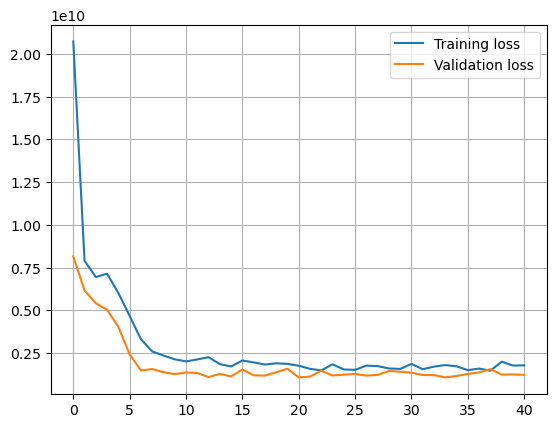

In [33]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.grid()
plt.legend()

In [34]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from itertools import product

# # Define Hyperparameter Grid
# param_grid = {
#     'lr': [0.1, 0.01],  # Learning rates
#     'batch_size': [32, 64],  # Different batch sizes
#     'optimizer': ['Adam', 'SGD'],  # Optimizer choice
#     'hidden_size': [64, 128]  # Number of neurons in hidden layer
# }

# # Generate all possible hyperparameter combinations
# param_combinations = list(product(*param_grid.values()))

# # Define Training Function
# def train_model(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs):
#     train_losses, valid_losses = train_v1(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs)
#     return min(valid_losses)  # Return lowest validation loss

# # Grid Search Loop
# best_loss = float('inf')
# best_params = None

# for params in param_combinations:
#     lr, batch_size, opt_name, hidden_size = params
#     print(f"Testing: lr={lr}, batch_size={batch_size}, optimizer={opt_name}, hidden_size={hidden_size}")

#     # Update Dataloader for different batch sizes
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

#     # Initialize model
#     torch.manual_seed(42)
#     model = MyModel(input_dim, hidden_size).to(device)
#     loss_fn = nn.MSELoss()

#     # Select Optimizer
#     if opt_name == 'Adam':
#         optimizer = optim.Adam(model.parameters(), lr=lr)
#     elif opt_name == 'SGD':
#         optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

#     # Train Model
#     final_loss = train_model(model, optimizer, loss_fn, train_loader, valid_loader, n_epochs=100)

#     # Track best parameters
#     if final_loss < best_loss:
#         best_loss = final_loss
#         best_params = params

# print("Best Hyperparameters:", best_params)


In [35]:
# Reinitialize the model architecture (same as training)
model = MyModel(input_dim).to(device)

# Load the saved weights
model.load_state_dict(torch.load("best_model.pth", weights_only=True))

# Set model to evaluation mode
model.eval()

MyModel(
  (model): Sequential(
    (0): Linear(in_features=213, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)

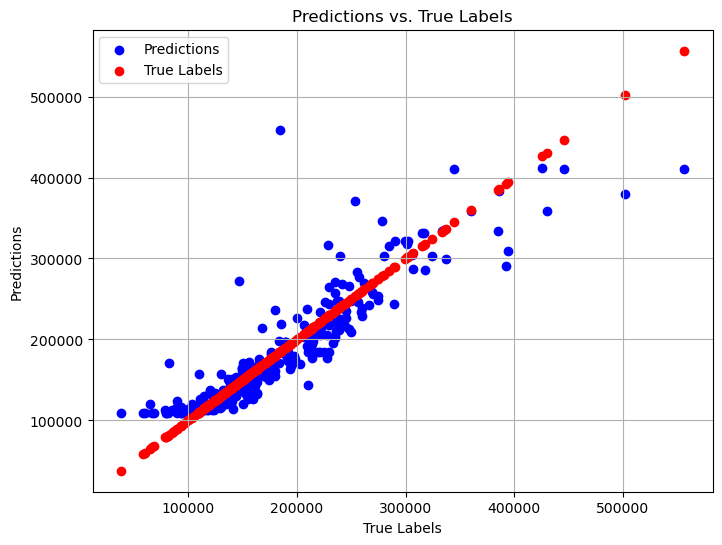

In [36]:
# Evaluating model with test set
predictions = []
true_labels = []

with torch.no_grad():  # No need to track gradients
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        
        # Forward pass
        y_test_pred = model(X_test_batch)
        
        # Store predictions and true values
        predictions.append(y_test_pred.cpu())  # Move to CPU for easier processing
        true_labels.append(y_test_batch.cpu())

# Convert list of tensors to a single tensor
predictions = torch.cat(predictions, dim=0)  # Concatenate along batch dimension
true_labels = torch.cat(true_labels, dim=0)


plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predictions, color='blue', label='Predictions')
plt.scatter(true_labels, true_labels, color='red', label='True Labels')
plt.title('Predictions vs. True Labels')
plt.xlabel('True Labels')
plt.ylabel('Predictions')
plt.grid(True)
plt.legend()
plt.show()
# import random

# # Select a random index
# random_index = random.randint(0, len(predictions) - 1)

# # Get the randomly chosen prediction and true label
# random_prediction = predictions[random_index].item()
# random_true_label = true_labels[random_index].item()

# # Display the result
# print(f"Randomly Selected Test Sample:")
# print(f"Predicted House Value: {random_prediction:.2f}")
# print(f"True House Value: {random_true_label:.2f}")

In [37]:
import random

# Select a random index
random_index = random.randint(0, len(predictions) - 1)

# Get the randomly chosen prediction and true label
random_prediction = predictions[random_index].item()
random_true_label = true_labels[random_index].item()

# Display the result
print(f"Randomly Selected Test Sample:")
print(f"Predicted House Value: {random_prediction:.2f}")
print(f"True House Value: {random_true_label:.2f}")

Randomly Selected Test Sample:
Predicted House Value: 108965.25
True House Value: 81000.00


#### **Task 2: Report on your model** - 5 marks

**Task deliverables**:
- Write a brief report (max. 300 words), answering the following questions:
    - What do you think about the performance of your model training in Task 1?
    - What could you try to do to improve the predictive performance of your model?
    - What did you find the most challenging when training the model and how did you solve it?


Write your report here (max. 300 words).

* Overall performance
My performance on model training in task 1 is generally OK. Most predictions are close to the actual price from prediction vs true labels.
However, there are still some outliers in the predictions, majorities of them are on high property price.
* Ways to improve the predcitive performance
We can improve predictive performance from both modelling and data perspectives.
From data persepective, we can get more data,
From modelling perspective, we can use other machine learning models such as RandomForrest or XGBoost, which is generally better than neural networks.
* THe most challenging when training models
I think the most challenging part is to find the right hyperparameters for the model. All hyperparameters are selected from typical numbers used online. With some iteration processes, correct results have obtained. 